# 3D LIDAR데이터를 2D Bird-Eye-view로 변환

본 슬라이드에서는 Lidar 물체탐지에서 자주 활용되는 기법으로 3D를 2D로 프로젝션 하는 법에 대하여 다루고 있습니다. 

코드는 [[여기]](http://ronny.rest/blog/post_2017_03_26_lidar_birds_eye/)를 참고 하였습니다. 

In [4]:
from PIL import Image
import numpy as np
import os

# ==============================================================================
#                                                                   SCALE_TO_255
# ==============================================================================
def scale_to_255(a, min, max, dtype=np.uint8):
    """ Scales an array of values from specified min, max range to 0-255
        Optionally specify the data type of the output (default is uint8)
    """
    return (((a - min) / float(max - min)) * 255).astype(dtype)


# ==============================================================================
#                                                          BIRDS_EYE_POINT_CLOUD
# ==============================================================================
def birds_eye_point_cloud(points,
                          side_range=(-10, 10),
                          fwd_range=(-10,10),
                          res=0.1,
                          min_height = -2.73,
                          max_height = 1.27,
                          saveto=None):
    """ Creates an 2D birds eye view representation of the point cloud data.
        You can optionally save the image to specified filename.

    Args:
        points:     (numpy array)
                    N rows of points data
                    Each point should be specified by at least 3 elements x,y,z
        side_range: (tuple of two floats)
                    (-left, right) in metres
                    left and right limits of rectangle to look at.
        fwd_range:  (tuple of two floats)
                    (-behind, front) in metres
                    back and front limits of rectangle to look at.
        res:        (float) desired resolution in metres to use
                    Each output pixel will represent an square region res x res
                    in size.
        min_height:  (float)(default=-2.73)
                    Used to truncate height values to this minumum height
                    relative to the sensor (in metres).
                    The default is set to -2.73, which is 1 metre below a flat
                    road surface given the configuration in the kitti dataset.
        max_height: (float)(default=1.27)
                    Used to truncate height values to this maximum height
                    relative to the sensor (in metres).
                    The default is set to 1.27, which is 3m above a flat road
                    surface given the configuration in the kitti dataset.
        saveto:     (str or None)(default=None)
                    Filename to save the image as.
                    If None, then it just displays the image.
    """
    x_lidar = points[:, 0]
    y_lidar = points[:, 1]
    z_lidar = points[:, 2]
    # r_lidar = points[:, 3]  # Reflectance

    # INDICES FILTER - of values within the desired rectangle
    # Note left side is positive y axis in LIDAR coordinates
    ff = np.logical_and((x_lidar > fwd_range[0]), (x_lidar < fwd_range[1]))
    ss = np.logical_and((y_lidar > -side_range[1]), (y_lidar < -side_range[0]))
    indices = np.argwhere(np.logical_and(ff,ss)).flatten()

    # CONVERT TO PIXEL POSITION VALUES - Based on resolution
    x_img = (-y_lidar[indices]/res).astype(np.int32) # x axis is -y in LIDAR
    y_img = (x_lidar[indices]/res).astype(np.int32)  # y axis is -x in LIDAR
                                                     # will be inverted later

    # SHIFT PIXELS TO HAVE MINIMUM BE (0,0)
    # floor used to prevent issues with -ve vals rounding upwards
    x_img -= int(np.floor(side_range[0]/res))
    y_img -= int(np.floor(fwd_range[0]/res))

    # CLIP HEIGHT VALUES - to between min and max heights
    pixel_values = np.clip(a = z_lidar[indices],
                           a_min=min_height,
                           a_max=max_height)

    # RESCALE THE HEIGHT VALUES - to be between the range 0-255
    pixel_values  = scale_to_255(pixel_values, min=min_height, max=max_height)

    # FILL PIXEL VALUES IN IMAGE ARRAY
    x_max = int((side_range[1] - side_range[0])/res)
    y_max = int((fwd_range[1] - fwd_range[0])/res)
    im = np.zeros([y_max, x_max], dtype=np.uint8)
    im[-y_img, x_img] = pixel_values # -y because images start from top left

    # Convert from numpy array to a PIL image
    im = Image.fromarray(im)

    # SAVE THE IMAGE
    if saveto is not None:
        im.save(saveto)
    else:
        im.show()

lidar_test = np.load('./data/ped_test/lidar_2000.npy')
birds_eye_point_cloud(lidar_test,
                      side_range=(-25, 25),
                      fwd_range=(-25,25),
                      res=0.1,
                      min_height = -5,
                      max_height = 15,
                      saveto = './data/ped_test_top_view/lidar_2000.png')

n = len(os.listdir('./data/ped_test/'))
print(n)

In [2]:
lidar_kitti = np.load('./extract_kiti/0005/lidar/lidar_0.npy')

In [3]:
birds_eye_point_cloud(lidar_kitti,
                  side_range=(-25, 25),
                  fwd_range=(-25,25),
                  res=0.1,
                  min_height = -5,
                  max_height = 15,
                  saveto = '/workspace/birdeyeview.png')

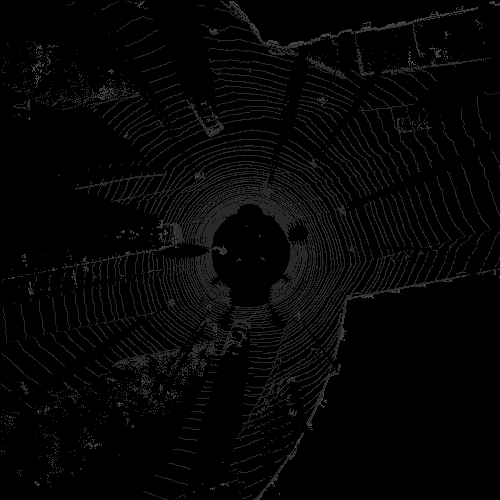

In [5]:
from IPython.display import Image
Image(filename='/workspace/birdeyeview.png') 

[참고:동영상 저장법] ffmpeg -r 60 -f image2 -s 500x500 -i lidar_%d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p test.mp4

In [1]:
from open3d import *

In [2]:
pcd = read_point_cloud("/workspace/_rosbag/lobby.pcd")
lidar_lobby= np.asarray(pcd.points)

In [5]:
birds_eye_point_cloud(lidar_lobby,
                  side_range=(-25, 25),
                  fwd_range=(-25,25),
                  res=0.1,
                  min_height = -5,
                  max_height = 15,
                  saveto = '/workspace/lobby_birdeyeview.png')

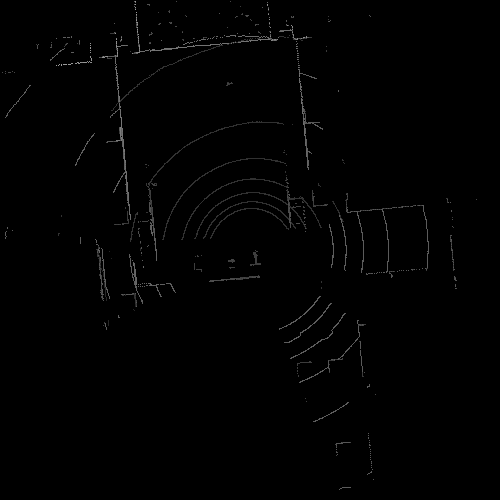

In [6]:
from IPython.display import Image
Image(filename='/workspace/lobby_birdeyeview.png') 